In [92]:
from orbitflows import HamiltonianMappingModel, generate_sho_orbits
import matplotlib.pyplot as plt
import numpy as np
import torch

In [97]:
model = HamiltonianMappingModel(input_dim=2, hidden_dim=128, num_layers=64)
model.flow

GsympNetFlow(
  (layers): ModuleList(
    (0-63): 64 x SymplecticCouplingLayer(
      (conditioner): GradientBasedConditioner()
    )
  )
)

In [98]:
n_actions = 1
n_angles = 1000
r_min = 0.5
r_max = 1.5
omega_guess = 1
training_data, aa_guess = generate_sho_orbits(n_actions, omega=omega_guess, t_end=10, n_steps=n_angles, r_bounds=[r_min,r_max]) #

Text(0.5, 1.0, 'Toy Orbits')

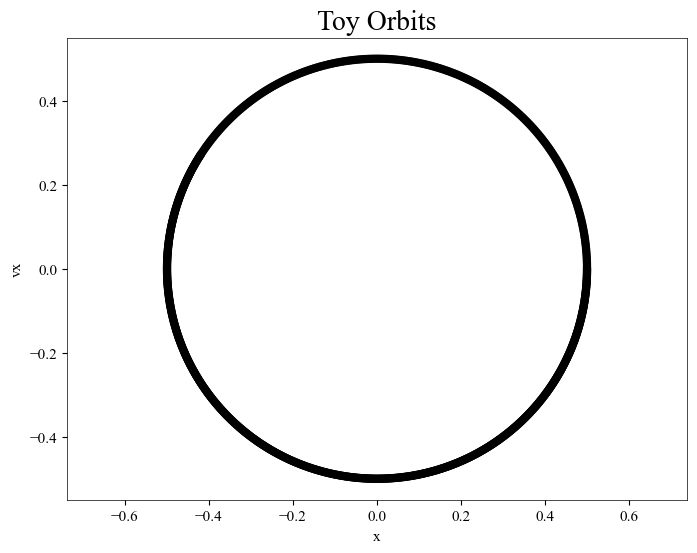

In [99]:
plt.scatter(*training_data.T)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('vx')
plt.title('Toy Orbits', fontsize=20)

training: 1500 step with 5 orbits
1000 steps with 20 orbits

In [100]:
def isoDiskPotential(x, amp=1, sigma=0.1):
    _H = sigma / torch.sqrt(torch.tensor([8.0 * torch.pi * amp]))[0]
    _sigma2 = sigma**2
    return 2.0 * _sigma2 * torch.log(torch.cosh(0.5 * x / _H))

steps = 200
model.train(isoDiskPotential, training_data, steps, learning_rate=1e-3)

100%|██████████| 200/200 [00:14<00:00, 13.51it/s]


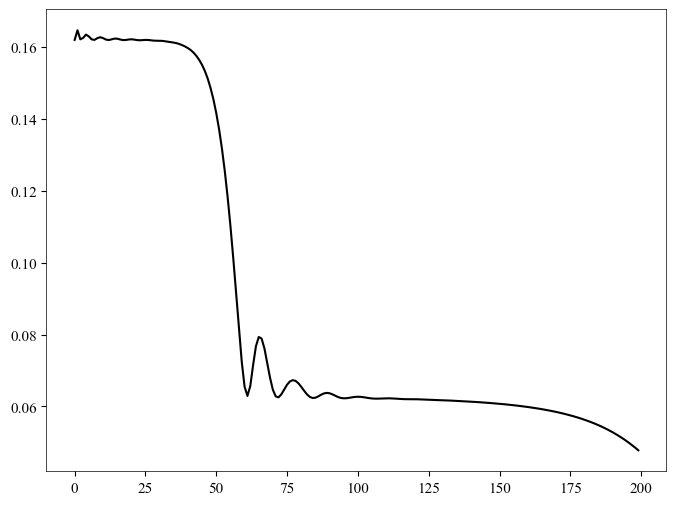

In [101]:
plt.plot(model.loss_list)

In [102]:
ps_nf = model.aa_to_ps(aa_guess)

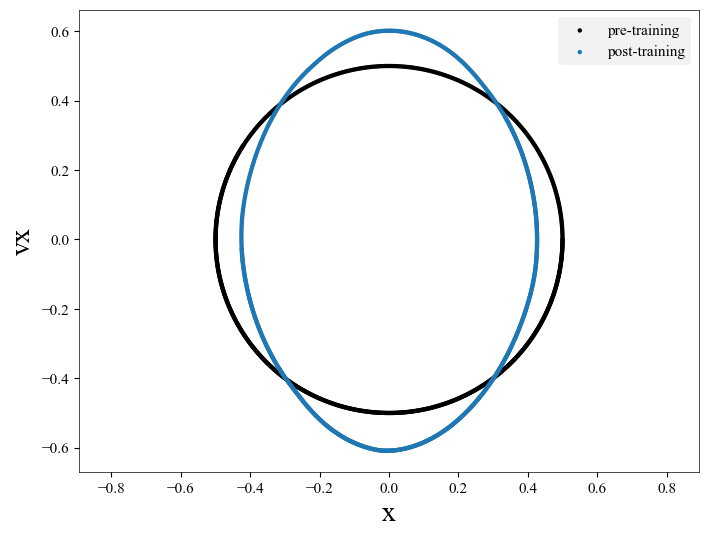

In [103]:
plt.scatter(*training_data.T.detach(), s=10, label='pre-training')
plt.scatter(*ps_nf.T.detach(), s=10, label='post-training')
plt.axis('equal')
plt.xlabel('x', fontsize=20)
plt.ylabel('vx', fontsize=20)
plt.legend()
plt.show()

In [104]:
from orbitflows import H

Text(0, 0.5, 'energy')

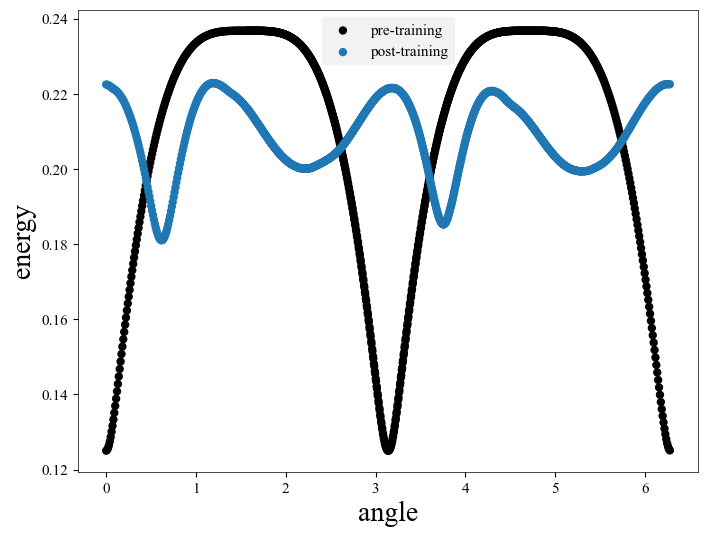

In [105]:
plt.scatter(aa_guess[...,0], H(training_data, model.targetPotential).detach(), label='pre-training')
plt.scatter(aa_guess[...,0], model.hamiltonian(aa_guess).detach(), label='post-training')
plt.legend()
plt.xlabel('angle', fontsize=20)
plt.ylabel('energy', fontsize=20)

In [106]:
# j_list = torch.linspace(0.1, 1.3, 1000, requires_grad=True)

# aa_list = torch.zeros((len(j_list), 2))
# aa_list[..., 1] = j_list
# h_list = model.hamiltonian(aa_list)
# plt.plot(j_list.detach(), h_list.detach())
# plt.xlabel('J', fontsize=20)
# plt.ylabel('H(J)', fontsize=20)

In [107]:
# model.frequency(aa_list)

In [108]:
# freq_list = torch.zeros(len(j_list))
# for i, aa in enumerate(aa_list):
#     freq_list[i] = model.frequency(aa)

In [109]:
# plt.plot(j_list.detach(), freq_list.detach())
# plt.xlabel('J', fontsize=20)
# plt.ylabel('$\Omega$(J)', fontsize=20)

In [111]:
aa0 = aa_guess[0][0].clone().requires_grad_(True)

In [112]:
steps = 100
t_end = 1
aa_integrated = model.integrate(aa0, steps, t_end)

100%|██████████| 100/100 [00:04<00:00, 22.10it/s]


Text(0, 0.5, 'H(t)')

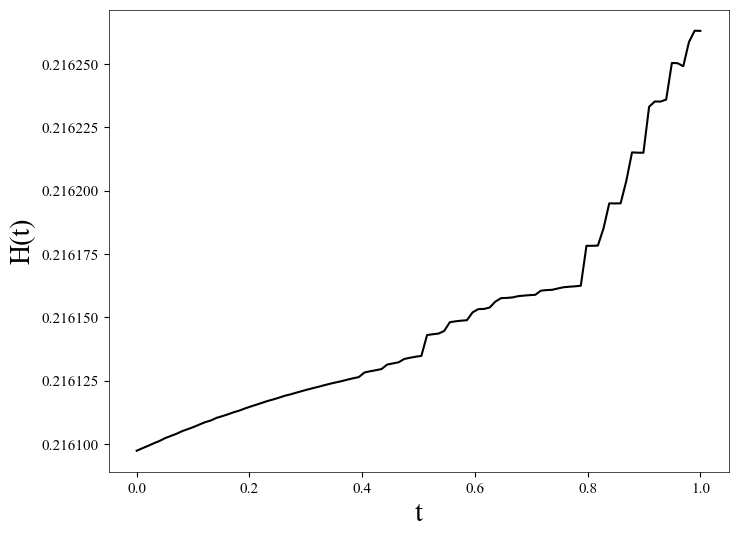

In [113]:
plt.plot(np.linspace(0, t_end, steps), model.hamiltonian(aa_integrated).detach())
plt.xlabel('t', fontsize=20)
plt.ylabel('H(t)', fontsize=20)

iteration 0:


100%|██████████| 100/100 [00:04<00:00, 21.71it/s]


iteration 1:


100%|██████████| 100/100 [00:04<00:00, 22.22it/s]


iteration 2:


100%|██████████| 100/100 [00:04<00:00, 21.42it/s]


iteration 3:


100%|██████████| 100/100 [00:04<00:00, 22.51it/s]


iteration 4:


100%|██████████| 100/100 [00:04<00:00, 21.55it/s]


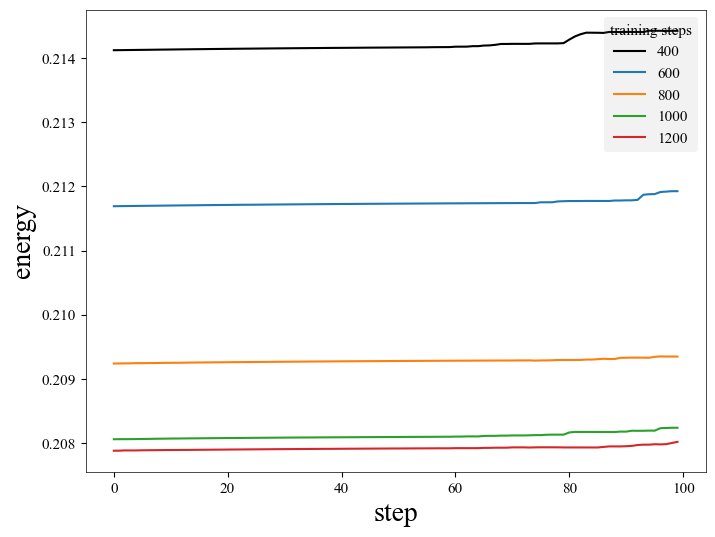

In [115]:
# check how integration improves after training more
initial_steps = len(model.loss_list)
for i in range(5):
    print(f'iteration {i}:')
    model.train(isoDiskPotential, training_data, 200)
    _aa_integrated = model.integrate(aa0, steps, t_end)
    plt.plot(np.linspace(0, t_end, steps), model.hamiltonian(_aa_integrated).detach(), label=f'{(i+1)* 200 + initial_steps}')
plt.xlabel('time', fontsize=20)
plt.ylabel('energy', fontsize=20)
plt.legend(title='training steps')
plt.show()

In [ ]:
# check how integration improves after training more
initial_steps = len(model.loss_list)
for i in range(5):
    print(f'iteration {i}:')
    model.train(isoDiskPotential, training_data, 200)
    _aa_integrated = model.integrate(aa0, steps, t_end)
    plt.plot(np.linspace(0, t_end, steps), model.hamiltonian(_aa_integrated).detach(), label=f'{(i+1)* 200 + initial_steps}')
plt.xlabel('time', fontsize=20)
plt.ylabel('energy', fontsize=20)
plt.legend(title='training steps')
plt.show()

In [122]:
model.hamiltonian(_aa_integrated).mean()

tensor(0.2079, grad_fn=<MeanBackward0>)

In [ ]:
# check how integration improves after training more
initial_steps = len(model.loss_list)
for i in range(5):
    print(f'iteration {i}:')
    model.train(isoDiskPotential, training_data, 200)
    _aa_integrated = model.integrate(aa0, steps, t_end)
    energy_error = (model.hamiltonian(_aa_integrated) - model.hamiltonian(_aa_integrated).mean())/model.hamiltonian(_aa_integrated).mean()
    plt.plot(np.linspace(0, t_end, steps), energy_error.detach(), label=f'{(i+1)* 200 + initial_steps}')
plt.xlabel('time', fontsize=20)
plt.ylabel('energy', fontsize=20)
plt.legend(title='training steps')
plt.show()

iteration 0:


100%|██████████| 10/10 [00:00<00:00, 20.93it/s]


iteration 1:


100%|██████████| 100/100 [00:04<00:00, 21.66it/s]


iteration 2:


100%|██████████| 1000/1000 [00:44<00:00, 22.25it/s]


iteration 3:


100%|██████████| 2000/2000 [01:29<00:00, 22.34it/s]


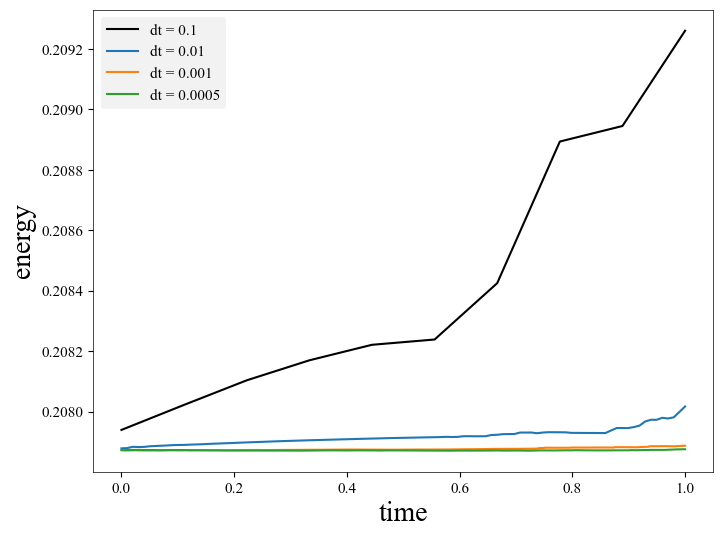

In [121]:
# check how changing time step improves after integration
t_end = 1
for i, dt in enumerate(np.array([0.1, 0.01, 0.001, 0.0005])):
    print(f'iteration {i}:')
    n_steps = int(t_end / dt)
    _aa_integrated = model.integrate(aa0, steps=n_steps, t_end=t_end)
    plt.plot(np.linspace(0, 1, n_steps), model.hamiltonian(_aa_integrated).detach(), label=f'dt = {dt}')
plt.xlabel('time', fontsize=20)
plt.ylabel('energy', fontsize=20)
plt.legend()
plt.show()

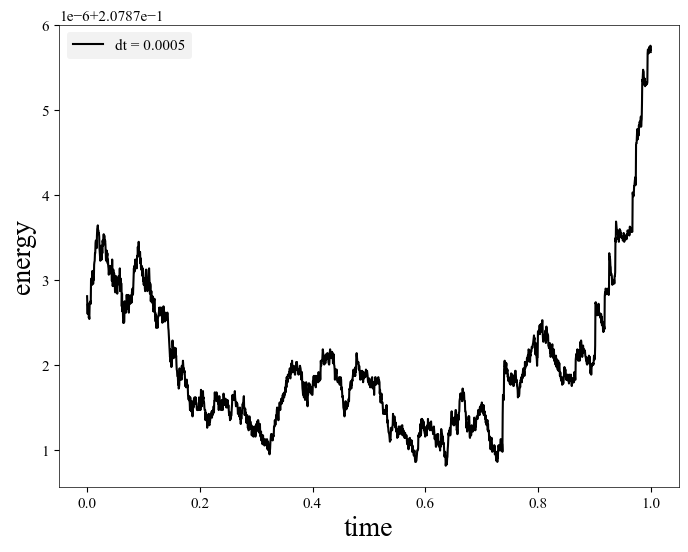

In [125]:
plt.plot(np.linspace(0, 1, n_steps), model.hamiltonian(_aa_integrated).detach(), label=f'dt = {dt}')
plt.xlabel('time', fontsize=20)
plt.ylabel('energy', fontsize=20)
plt.legend()

Text(0, 0.5, 'energy')

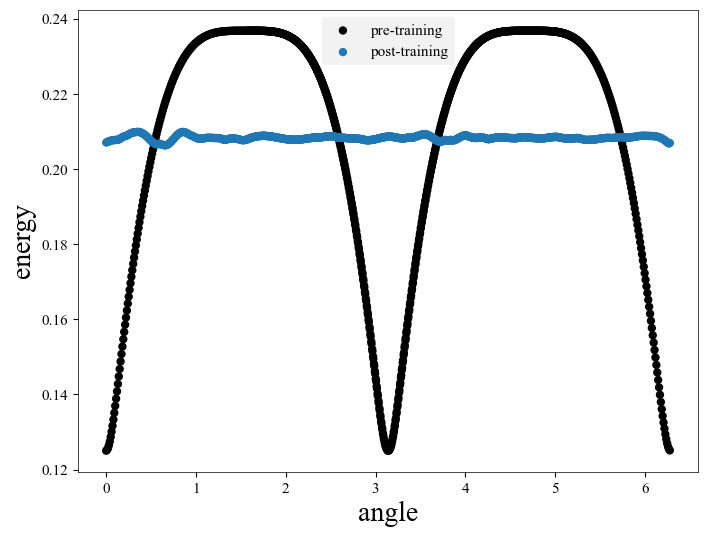

In [126]:
plt.scatter(aa_guess[...,0], H(training_data, model.targetPotential).detach(), label='pre-training')
plt.scatter(aa_guess[...,0], model.hamiltonian(aa_guess).detach(), label='post-training')
plt.legend()
plt.xlabel('angle', fontsize=20)
plt.ylabel('energy', fontsize=20)